# Tutorial for `Eulearning` package

**Authors:** Olympio Hacquard and Vadim Lebovici

In this notebook, we illustrate the computation of Euler characteristic descriptors on a toy point clouds. We compute Euler characteristic curve and surfaces as well as their Radon and hybrid transforms. The multi-parameter filtrations we consider are function-alpha filtration associated to a kernel density estimate post-composed with a decreasing function.

To see an example on graph data, see the demo `graphs.ipynb`.

----

**Preliminary**: adding the right folder to path.

In [1]:
import sys
sys.path.append('../')

# Generating toy examples
We generate two point clouds made of respectively one and two dense lines in a uniform background noise.

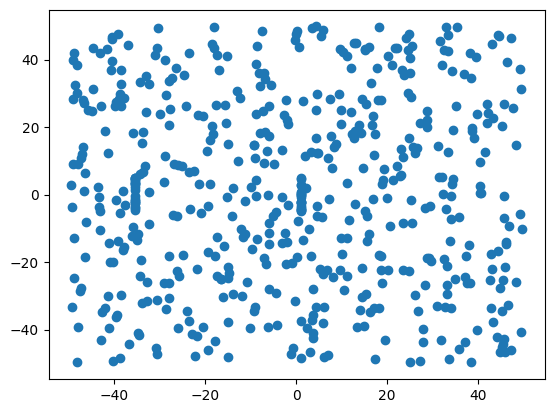

In [2]:
import matplotlib.pyplot as plt
from eulearning.datasets import gen_dense_lines_with_noise

X = gen_dense_lines_with_noise(n_pattern=2)

plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.show()

# Computing one-parameter Euler characteristic descriptors
We compute the Euler characteristic curves of above filtrations, as well as their hybrid transforms.
### Alpha filtrations
We compute the alpha complexes and vectorize the simplex trees.

In [3]:
import numpy as np
import gudhi as gd
from eulearning.utils import vectorize_st

ac = gd.AlphaComplex(X)			# Initialize the alpha complex
st = ac.create_simplex_tree() 		# Compute the alpha filtration
vec_st = vectorize_st(st)		# Vectorize the simplex tree

### Euler characteristic curves
Recall that, in practice, our implementation allows for several ways of choosing a grid of sampling. The first method is to provide a list `val_ranges` of bounds $[(a_1,b_1), \ldots, (a_m,b_m)]$ and a tuple `resolution` of the form $(d_1, \ldots, d_m)$. We then compute a sampling of our descriptors on a uniform discretization of the subset $[a_1,b_1]\times\ldots\times[a_m,b_m]\subseteq \R^m$. This method has the disadvantage of requiring prior knowledge on data. 

The second way does not require any prior knowledge on data but depends on a choice of parameters. For Euler characteristic profiles, the second way is to provide `resolution` and a list `quantiles` of the form $[(p_1,q_1), \ldots, (p_m, q_m)]$ of real numbers $0\leq p_i < q_i \leq 1$. The algorithm then computes the $p_i$-th and the $q_i$-th percentiles of the $i$-th filtration for each $i=1,\ldots,m$. Finally, the Euler profiles are uniformly sampled on a $d_1\times\ldots\times d_m$ grid ranging from the lowest to the highest percentile on each axis. 

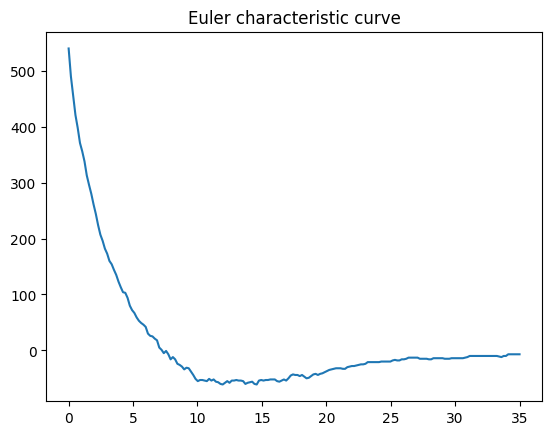

In [4]:
from eulearning.descriptors import EulerCharacteristicProfile

# Choose your method to compute Euler characteristic curves
## e.g. using quantiles
euler_curve = EulerCharacteristicProfile(resolution=(200,), quantiles=[(0, 0.95)], pt_cld=True, normalize=False)

## e.g. using specified bounds
euler_curve = EulerCharacteristicProfile(resolution=(200,), val_ranges=[(0, 35)], pt_cld=True, normalize=False)

# Compute Euler curves
ecc = euler_curve.fit_transform(vec_st)

# Plot Euler curves
ecc_range = np.linspace(euler_curve.val_ranges[0][0], euler_curve.val_ranges[0][1], euler_curve.resolution[0])
plt.figure()
plt.plot(ecc_range, ecc)
plt.title('Euler characteristic curve')
plt.show()

### Hybrid transforms
For the Radon and hybrid transforms, the second way differs slightly. It consists in providing a list `quantiles` of the form $[p_1, \ldots, p_m]$ of real numbers $0\leq p_i \leq 1$ and a positive real number `stretch_factor`. The algorithm then computes the $p_i$-th percentiles $v_i$ of the $i$-th filtration for each $i=1,\ldots,m$. The integral transforms are uniformly sampled on a $d_1\times\ldots\times d_m$ grid ranging from $0$ to `stretch_factor`$/v_i$ on each axis. By default, `stretch_factor=4`. See the Section 3.1 of the online version of the article for a justification.

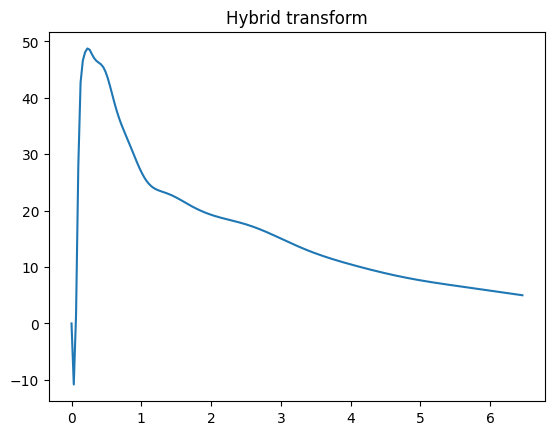

In [5]:
from eulearning.descriptors import HybridTransform

# Choose your method to compute hybrid transform
## e.g. using specified bounds and a specified kernel:
kernel = lambda x:np.exp(np.cos(x))
hyb_trans = HybridTransform(resolution=(200,), val_ranges=[(0,5)], kernel=kernel, pt_cld=True, normalize=False)

## e.g. using quantiles and a keyword kernel:
# Available keyword kernels are : 
# 		- 'exp_p' 		: lambda x: np.exp(-np.abs(x)**p)
# 		- 'wavelet_p' 	: lambda x: x**p * np.exp(-x**p)
# 		- 'cos_p' 		: lambda x: np.cos(x**p)
hyb_trans = HybridTransform(resolution=(200,), quantiles=[0.05], kernel_name='wavelet_4', pt_cld=True, normalize=False)

# Compute hybrid transform
ht = hyb_trans.fit_transform(vec_st)

# Plot hybrid transform
ht_range = np.linspace(hyb_trans.val_ranges[0][0], hyb_trans.val_ranges[0][1], hyb_trans.resolution[0])
plt.figure()
plt.plot(ht_range, ht)
plt.title('Hybrid transform')
plt.show()

# Two-parameter Euler characteristic descriptors
We now compute the Euler characteristic surfaces of two-parameter function-alpha filtration build from a estimated density on the point cloud. We also compute the associated hybrid transforms.

### Multi-parameter filtrations
We compute the codensity filtration and add it to the re-vectorize simplex trees with it.

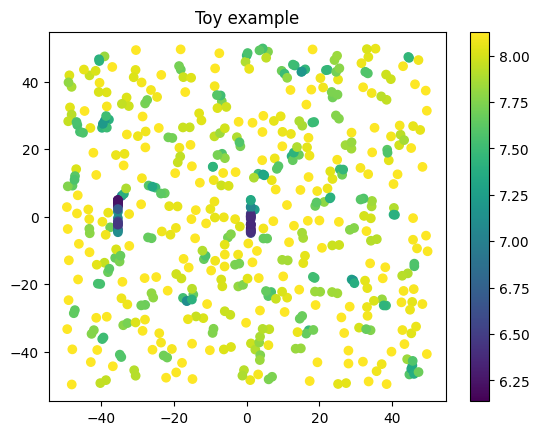

In [6]:
from eulearning.utils import codensity

X_ = np.array([ac.get_point(i) for i in  range(st.num_vertices())]) 	# For technical reasons, computation of the alpha complex may change the order of vertices
codensity_filt = codensity(X_)						# Compute codensity of each point cloud
vec_st2 = vectorize_st(st, filtrations=[codensity_filt])		# Vectorize the simplex tree

plt.figure()
plt.scatter(X[:,0], X[:,1], c=codensity_filt)
plt.colorbar()
plt.title('Toy example')
plt.show()

### Euler characteristic profiles

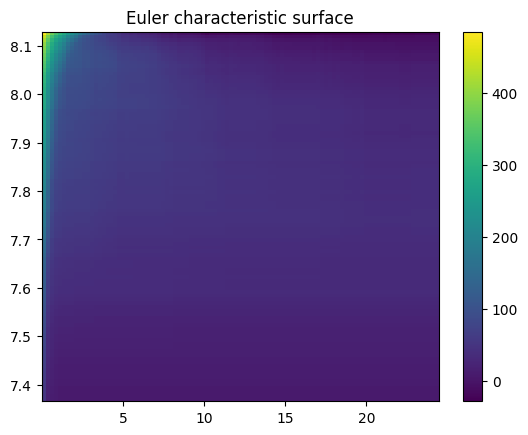

In [7]:
from eulearning.descriptors import EulerCharacteristicProfile

euler_profile = EulerCharacteristicProfile(resolution=(100,100), quantiles=[(0, 0.9), (0.1,0.9)], pt_cld=True, normalize=False, flatten=False)
ecs = euler_profile.fit_transform(vec_st2)

# Plot the result
extent = list(euler_profile.val_ranges[0]) + list(euler_profile.val_ranges[1])
plt.figure()
plt.imshow(ecs, origin='lower', extent=extent, aspect='auto')
plt.colorbar()
plt.title('Euler characteristic surface')
plt.show()

### Hybrid transforms

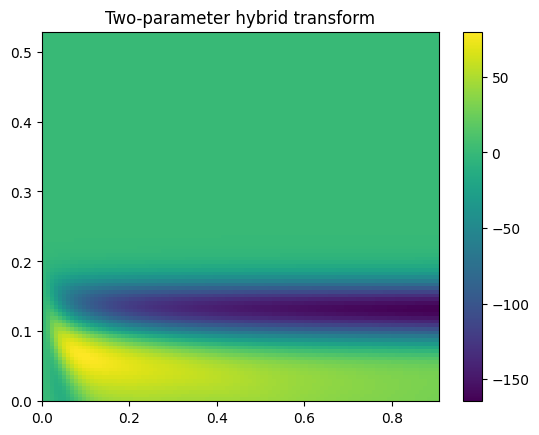

In [8]:
from eulearning.descriptors import HybridTransform

hybrid_transform2 = HybridTransform(resolution=(100,100), quantiles=[0.3, 0.2], kernel_name='wavelet_4', pt_cld=True, normalize=False, flatten=False)
multi_ht = hybrid_transform2.fit_transform(vec_st2)

extent = list(hybrid_transform2.val_ranges[0]) + list(hybrid_transform2.val_ranges[1])
plt.figure()
plt.imshow(multi_ht, origin='lower', extent=extent, aspect='auto')
plt.colorbar()
plt.title('Two-parameter hybrid transform')
plt.show()

### Radon transform

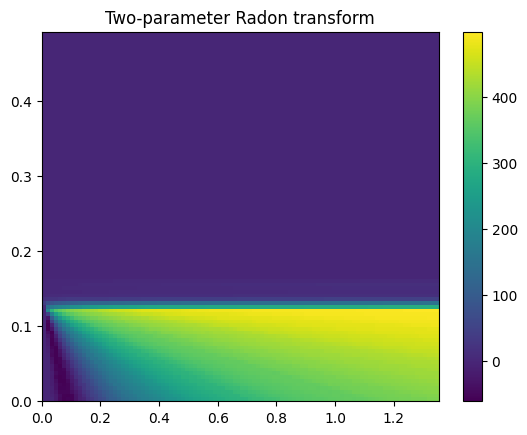

In [9]:
from eulearning.descriptors import RadonTransform

radon_transform = RadonTransform(resolution=(100,100), quantiles=[0.2, 1], pt_cld=True, normalize=False, flatten=False)
rdn = radon_transform.fit_transform(vec_st2)
extent = list(radon_transform.val_ranges[0])+list(radon_transform.val_ranges[1])

plt.figure()
plt.imshow(rdn, origin='lower', extent=extent, aspect='auto')
plt.colorbar()
plt.title('Two-parameter Radon transform')
plt.show()